In [1]:
from random import randint

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro.infer import ELBO
from numpyro.contrib.einstein import kernels, Stein
from numpyro.infer.autoguide import AutoDelta
from numpyro.infer.initialization import init_with_noise, init_to_value
from numpyro.contrib.einstein.callbacks import Progbar

In [2]:
rng_key = jax.random.PRNGKey(randint(0, int(1e6)))
num_iterations = 6000

In [3]:
def model():
    numpyro.sample('x', dist.MultivariateNormal(loc=jnp.array([5., 10.]), covariance_matrix=[[3., 5.], 
                                                                                             [5., 10.]]))

In [4]:
guide = AutoDelta(model)
svgd = Stein(model, guide, numpyro.optim.Adagrad(step_size=1.0), ELBO(),
             kernels.RBFKernel(mode='vector') ,
             init_strategy=init_with_noise(init_to_value(values={'x': jnp.array([-10., 30.])}), noise_scale=1.0),
             num_particles=100)
svgd_state = svgd.init(rng_key)

/usr/local/Caskroom/miniconda/base/envs/numpyro-stein/lib/python3.8/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


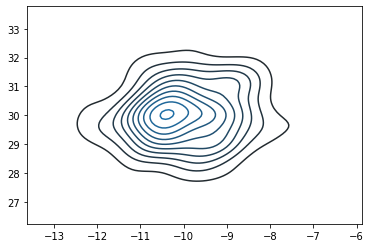

In [5]:
sns.kdeplot(svgd.get_params(svgd_state)['auto_x'][:, 0], svgd.get_params(svgd_state)['auto_x'][:, 1])


In [6]:
svgd_state, loss = svgd.run(rng_key, num_iterations, callbacks=[Progbar()])

/usr/local/Caskroom/miniconda/base/envs/numpyro-stein/lib/python3.8/site-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)
Stein 3.5967: 100%|██████████| 6000/6000 [00:28<00:00, 209.22it/s]


/usr/local/Caskroom/miniconda/base/envs/numpyro-stein/lib/python3.8/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


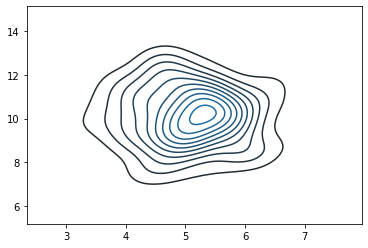

In [7]:
plt.clf()
sns.kdeplot(svgd.get_params(svgd_state)['auto_x'][:, 0], svgd.get_params(svgd_state)['auto_x'][:, 1])

In [8]:
svgd.get_params(svgd_state)['auto_x']

DeviceArray([[ 6.620818 ,  8.853896 ],
             [ 4.8140206, 10.241575 ],
             [ 5.722423 , 10.811262 ],
             [ 4.2267246, 10.762    ],
             [ 5.7491746, 10.173339 ],
             [ 4.147803 , 10.986756 ],
             [ 5.296249 , 11.250051 ],
             [ 4.297841 ,  9.122346 ],
             [ 5.8327036,  9.786143 ],
             [ 5.4933224,  9.596884 ],
             [ 4.6143236, 12.589705 ],
             [ 4.635023 ,  9.206716 ],
             [ 5.2780337, 10.918762 ],
             [ 4.1048894,  9.856074 ],
             [ 5.9712143,  9.703378 ],
             [ 5.601483 ,  9.156158 ],
             [ 4.938404 , 11.874376 ],
             [ 6.3633175, 10.741323 ],
             [ 5.0987387, 10.574844 ],
             [ 5.149432 ,  8.695286 ],
             [ 4.8840175,  9.925287 ],
             [ 5.115655 ,  8.902948 ],
             [ 4.731632 , 10.877864 ],
             [ 5.5359473, 10.625972 ],
             [ 6.0156755, 10.188892 ],
             [ 4.264248 ,

In [9]:
guide = AutoDelta(model)
svgd = Stein(model, guide, numpyro.optim.Adagrad(step_size=1.0), ELBO(), kernels.GraphicalKernel(),
             init_strategy=init_with_noise(init_to_value(values={'x': jnp.array([-10., 30.])}), noise_scale=1.0),
             num_particles=100)
svgd_state = svgd.init(rng_key)

In [10]:
svgd_state, loss = svgd.run(rng_key, num_iterations, callbacks=[Progbar()])

/usr/local/Caskroom/miniconda/base/envs/numpyro-stein/lib/python3.8/site-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)
Stein 3.5749: 100%|██████████| 6000/6000 [00:36<00:00, 164.45it/s]


/usr/local/Caskroom/miniconda/base/envs/numpyro-stein/lib/python3.8/site-packages/jax/lax/lax.py:5905: UserWarning: Explicitly requested dtype <class 'numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


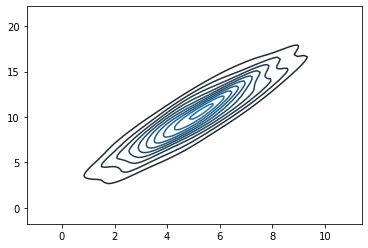

In [11]:
plt.clf()
sns.kdeplot(svgd.get_params(svgd_state)['auto_x'][:, 0], svgd.get_params(svgd_state)['auto_x'][:, 1])